# Standard SWEI and Heldmyer et. al. Drought classification comparison workflow

In [1]:
# Install the snowdroughtindex package
#%pip install git+https://github.com/Nadiesenali/snowdroughtindex-main

# Import required packages
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy.integrate import trapz
from scipy.stats import norm

# Import snowdroughtindex package
from snowdroughtindex.core import data_preparation, gap_filling, sswei
from snowdroughtindex.utils import visualization

# 1. Data Loading

In [2]:
SWE_path = 'C:/Users/walimunige.rupasingh/OneDrive - University of Calgary/Documents/Reasearch/Conferences/CWRA2025/DATA/in_puts/SWE_basin.csv'
P_path = 'C:/Users/walimunige.rupasingh/OneDrive - University of Calgary/Documents/Reasearch/Conferences/CWRA2025/DATA/in_puts/daily_precipitation_RDRS.nc'
Bow_at_Banff = 'C:/Users/walimunige.rupasingh/OneDrive - University of Calgary/Documents/Reasearch/Snow_drought_indicator/snowdroughtindex/data/input_data/Bow_at_Banff/basins_testcases.shp'
output_path = 'C:/Users/walimunige.rupasingh/OneDrive - University of Calgary/Documents/Reasearch/Conferences/CWRA2025/DATA/out_puts/'

# 2. Plot data points on shapefile

In [3]:
# Load SWE NetCDF data
SWE = pd.read_csv(SWE_path)

# Convert the SWE data to a GeoDataFrame
geometry = [Point(xy) for xy in zip(SWE['lon'], SWE['lat'])]
crs = {'init': 'epsg:4326'}
SWE_gdf = gpd.GeoDataFrame(SWE, crs=crs, geometry=geometry)

# Load precipitation data
P = xr.open_dataset(P_path)
# Convert to geodataframe
P = P.to_dataframe()

# P data to geodataframe
P_data = P.reset_index()
geometry = [Point(xy) for xy in zip(P_data['lon'], P_data['lat'])]
P_data = P_data.drop(['lon', 'lat'], axis=1)
crs = {'init': 'epsg:4326'}
P_data = gpd.GeoDataFrame(P_data, crs=crs, geometry=geometry)

# Load shapefile
basin = gpd.read_file(Bow_at_Banff)

# Create a GeoDataFrame with the point location
point_location = gpd.GeoDataFrame(
    geometry=[Point(-115.571, 51.178)],
    crs=basin.crs
)

#select Bow river at banff basin
basin = basin[basin['Station_ID'] == '05BB001']



c:\Users\walimunige.rupasingh\AppData\Local\anaconda3\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\walimunige.rupasingh\AppData\Local\anaconda3\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


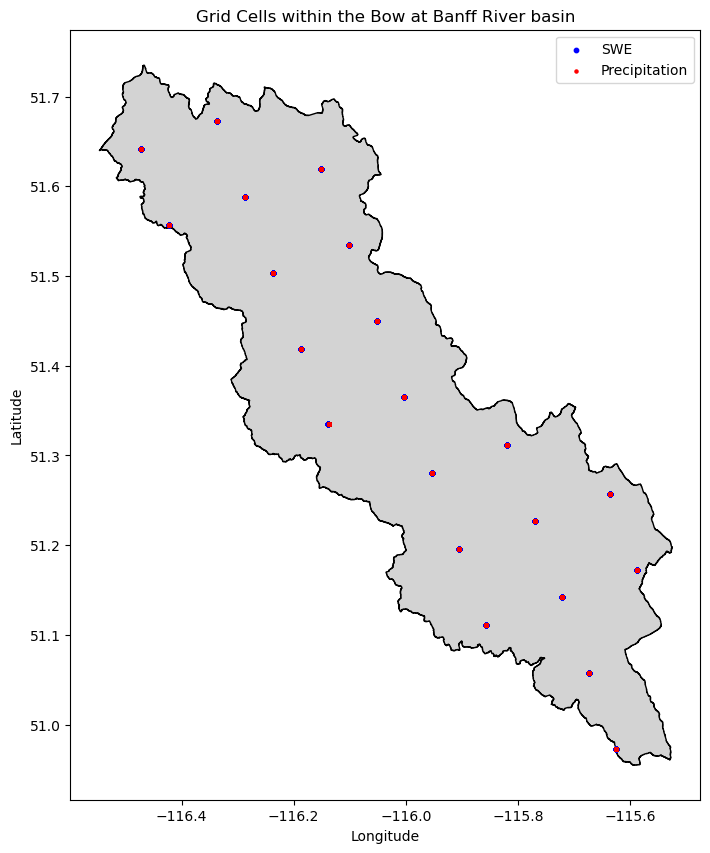

In [31]:
#plot data points on the shapefile
fig, ax = plt.subplots(figsize=(10, 10))    
basin.plot(ax=ax, color='lightgrey', edgecolor='black')
SWE_gdf.plot(ax=ax, color='blue', markersize=10, label='SWE')
P_data.plot(ax=ax, color='red', markersize=5, label='Precipitation')
ax.set_title('Grid Cells within the Bow at Banff River basin')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
# Save the plot
plt.savefig(output_path + 'Bow_at_Banff_basin_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Calculation of climatological mean SWE

In [32]:
display(SWE_gdf.head())
display(P_data.head())

,Unnamed: 0,rlat,rlon,time,lat,lon,SWE,geometry,index_right,Station_ID,Station_Na,Area_km2,Source
0,1915440,NaN,NaN,1980-01-02,50.972347,-115.625092,145.514252,POINT (-115.62509 50.97235),0,05BB001,BOW RIVER AT BANFF,2210.56,WSC_HYDAT
1,1915441,NaN,NaN,1980-01-03,50.972347,-115.625092,147.135864,POINT (-115.62509 50.97235),0,05BB001,BOW RIVER AT BANFF,2210.56,WSC_HYDAT
2,1915442,NaN,NaN,1980-01-04,50.972347,-115.625092,146.875717,POINT (-115.62509 50.97235),0,05BB001,BOW RIVER AT BANFF,2210.56,WSC_HYDAT
3,1915443,NaN,NaN,1980-01-05,50.972347,-115.625092,145.956879,POINT (-115.62509 50.97235),0,05BB001,BOW RIVER AT BANFF,2210.56,WSC_HYDAT
4,1915444,NaN,NaN,1980-01-06,50.972347,-115.625092,146.863937,POINT (-115.62509 50.97235),0,05BB001,BOW RIVER AT BANFF,2210.56,WSC_HYDAT


,time,coordinate_id,daily_precipitation,geometry
0,1980-01-01,1,0.254825,POINT (-115.62509 50.97234)
1,1980-01-02,1,0.362730,POINT (-115.62509 50.97234)
2,1980-01-03,1,1.083391,POINT (-115.62509 50.97234)
3,1980-01-04,1,0.093789,POINT (-115.62509 50.97234)
4,1980-01-05,1,0.339676,POINT (-115.62509 50.97234)


In [33]:
# get basin mean SWE
SWE_basin_mean = SWE.groupby('time').mean()
SWE_basin_mean = SWE_basin_mean.reset_index()

display(SWE_basin_mean)

C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_38800\1242323407.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  SWE_basin_mean = SWE.groupby('time').mean()


,time,Unnamed: 0,rlat,rlon,lat,lon,SWE,index_right,Area_km2
0,1980-01-02,3.182486e+06,NaN,NaN,51.352908,-115.997001,145.297458,0.0,2210.56
1,1980-01-03,3.182487e+06,NaN,NaN,51.352908,-115.997001,148.070760,0.0,2210.56
2,1980-01-04,3.182488e+06,NaN,NaN,51.352908,-115.997001,148.233443,0.0,2210.56
3,1980-01-05,3.182489e+06,NaN,NaN,51.352908,-115.997001,148.978573,0.0,2210.56
4,1980-01-06,3.182490e+06,NaN,NaN,51.352908,-115.997001,149.213135,0.0,2210.56
...,...,...,...,...,...,...,...,...,...
13875,2017-12-28,3.196361e+06,NaN,NaN,51.352908,-115.997001,147.322401,0.0,2210.56
13876,2017-12-29,3.196362e+06,NaN,NaN,51.352908,-115.997001,152.284639,0.0,2210.56
13877,2017-12-30,3.196363e+06,NaN,NaN,51.352908,-115.997001,159.335216,0.0,2210.56
13878,2017-12-31,3.196364e+06,NaN,NaN,51.352908,-115.997001,160.474173,0.0,2210.56


In [34]:
# Reset the index to make 'time' a regular column
SWE_data_reset = SWE_basin_mean.reset_index()

# Convert 'time' column to datetime
SWE_data_reset['time'] = pd.to_datetime(SWE_data_reset['time'])

# get peak SWE for each year 1981-2010
peak_SWE = SWE_data_reset[SWE_data_reset['time'].dt.year.isin(range(1981, 2011))].groupby(
    SWE_data_reset['time'].dt.year)['SWE'].max().reset_index()

# Rename the columns for clarity
peak_SWE.columns = ['Year', 'peak_SWE']

# Display the result
display(peak_SWE)

#get average peak SWE for 1981-2010
average_peak_SWE = peak_SWE['peak_SWE'].mean()
print(average_peak_SWE)

# save the peak SWE data
peak_SWE.to_csv(output_path + 'peak_SWE.csv', index=False)

,Year,peak_SWE
0,1981,277.028751
1,1982,274.280443
2,1983,196.746325
3,1984,193.918475
4,1985,190.932394
5,1986,318.156984
6,1987,236.095692
7,1988,199.416064
8,1989,260.143244
9,1990,293.947982


247.93135218544612


In [58]:
# 5% of the average peak SWE
min_SWE = 0.05 * average_peak_SWE
print(min_SWE)

12.396567609272306


In [40]:
# Add a unique coordinate_id for each grid point
SWE['coordinate_id'] = SWE.groupby(['geometry']).ngroup()

# strart coordinate_id from 1
SWE['coordinate_id'] = SWE['coordinate_id'] + 1

# keep only time, coordinate_id and SWE columns
SWE = SWE[['time', 'coordinate_id', 'SWE']]
SWE = SWE.reset_index()

# Display the updated dataframe
display(SWE.head())

,index,time,coordinate_id,SWE
0,0,1980-01-02,2,145.514252
1,1,1980-01-03,2,147.135864
2,2,1980-01-04,2,146.875717
3,3,1980-01-05,2,145.956879
4,4,1980-01-06,2,146.863937


In [41]:
# print number of coordinate_id
print(SWE['coordinate_id'].nunique())

# print what coordinates are in the SWE_basin_grid
print(SWE['coordinate_id'].unique())

21
[ 2  4  8  5  1  9  6  3 10  7 14 11 16 12 17 13 20 18 15 21 19]


In [42]:
# keep only time, coordinate_id and daily_precipitation columns
P_data = P_data[['time', 'coordinate_id', 'daily_precipitation']]
P_data = P_data.reset_index()

display(P_data)

# print number of coordinate_id
print(P_data['coordinate_id'].nunique())

# print what coordinates are in the SWE_basin_grid
print(P_data['coordinate_id'].unique())

,index,time,coordinate_id,daily_precipitation
0,0,1980-01-01,1,0.254825
1,1,1980-01-02,1,0.362730
2,2,1980-01-03,1,1.083391
3,3,1980-01-04,1,0.093789
4,4,1980-01-05,1,0.339676
...,...,...,...,...
299140,299140,2018-12-27,21,0.101965
299141,299141,2018-12-28,21,0.621428
299142,299142,2018-12-29,21,1.788441
299143,299143,2018-12-30,21,4.915802


21
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


In [43]:
# Convert the 'time' column in SWE_basin_grid to datetime
SWE['time'] = pd.to_datetime(SWE['time'])

# merge SWE and P data on time and coordinate_id
SWE_P = pd.merge(SWE, P_data, on=['time', 'coordinate_id'], how='inner')

display(SWE_P)

,index_x,time,coordinate_id,SWE,index_y,daily_precipitation
0,0,1980-01-02,2,145.514252,14246,0.405467
1,1,1980-01-03,2,147.135864,14247,0.715090
2,2,1980-01-04,2,146.875717,14248,0.127141
3,3,1980-01-05,2,145.956879,14249,0.335644
4,4,1980-01-06,2,146.863937,14250,0.023826
...,...,...,...,...,...,...
291475,291475,2017-12-28,19,200.170135,270286,1.269858
291476,291476,2017-12-29,19,203.859009,270287,2.823314
291477,291477,2017-12-30,19,207.367249,270288,5.096675
291478,291478,2017-12-31,19,209.167236,270289,0.075292


In [44]:
# print number of coordinate_id
print(SWE_P['coordinate_id'].nunique())

# print what coordinates are in the SWE_basin_grid
print(SWE_P['coordinate_id'].unique())

21
[ 2  4  8  5  1  9  6  3 10  7 14 11 16 12 17 13 20 18 15 21 19]


In [59]:
# Ensure 'time' column is in datetime format
SWE_P['time'] = pd.to_datetime(SWE_P['time'])

# Define water year for each coordinate_id time series
water_year_grid = SWE_P[(SWE_P['time'].dt.month >= 10) | (SWE_P['time'].dt.month <= 9)]
water_year_grid['Season_year'] = water_year_grid['time'].dt.year
water_year_grid['Season_year'] = water_year_grid['Season_year'].where(water_year_grid['time'].dt.month >= 10, water_year_grid['Season_year'] - 1)

# drop 1979
water_year_grid = water_year_grid[water_year_grid['Season_year'] >= 1980]
#drop 2017
water_year_grid = water_year_grid[water_year_grid['Season_year'] <= 2016]
# Display the updated dataframe
display(water_year_grid)

,index_x,time,coordinate_id,SWE,index_y,daily_precipitation,Season_year
273,273,1980-10-01,2,0.659927,14519,0.007485,1980
274,274,1980-10-02,2,0.653784,14520,0.100362,1980
275,275,1980-10-03,2,0.000000,14521,0.000000,1980
276,276,1980-10-04,2,0.000000,14522,0.000162,1980
277,277,1980-10-05,2,0.000000,14523,0.000197,1980
...,...,...,...,...,...,...,...
291382,291382,2017-09-26,19,17.427170,270193,0.808129,2016
291383,291383,2017-09-27,19,15.287083,270194,0.285076,2016
291384,291384,2017-09-28,19,12.276982,270195,0.019227,2016
291385,291385,2017-09-29,19,8.637960,270196,0.000000,2016


In [61]:
# Rearrange the columns in the desired order
SWE_P_rearranged = water_year_grid[['time', 'coordinate_id', 'SWE', 'daily_precipitation', 'Season_year']]

# Rename the columns for clarity
SWE_P_rearranged.columns = ['time', 'coordinate_id', 'SWE', 'P','season_year']

# Display the rearranged dataframe
display(SWE_P_rearranged)

,time,coordinate_id,SWE,P,season_year
273,1980-10-01,2,0.659927,0.007485,1980
274,1980-10-02,2,0.653784,0.100362,1980
275,1980-10-03,2,0.000000,0.000000,1980
276,1980-10-04,2,0.000000,0.000162,1980
277,1980-10-05,2,0.000000,0.000197,1980
...,...,...,...,...,...
291382,2017-09-26,19,17.427170,0.808129,2016
291383,2017-09-27,19,15.287083,0.285076,2016
291384,2017-09-28,19,12.276982,0.019227,2016
291385,2017-09-29,19,8.637960,0.000000,2016


In [69]:
# Calculate daily SWE change considering each coordinate_id
SWE_P_rearranged['daily_SWE_change'] = SWE_P_rearranged.groupby(['coordinate_id', 'season_year'])['SWE'].diff().shift(-1)
SWE_P_rearranged['daily_SWE_change'] = SWE_P_rearranged['daily_SWE_change'].fillna(0)
SWE_P_rearranged.loc[SWE_P_rearranged['daily_SWE_change'] < 0, 'daily_SWE_change'] = 0

# Display the updated DataFrame
display(SWE_P_rearranged)

C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_38800\2641637885.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SWE_P_rearranged['daily_SWE_change'] = SWE_P_rearranged.groupby(['coordinate_id', 'season_year'])['SWE'].diff().shift(-1)
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_38800\2641637885.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SWE_P_rearranged['daily_SWE_change'] = SWE_P_rearranged['daily_SWE_change'].fillna(0)


,time,coordinate_id,SWE,P,season_year,daily_SWE_change
273,1980-10-01,2,0.659927,0.007485,1980,0.0
274,1980-10-02,2,0.653784,0.100362,1980,0.0
275,1980-10-03,2,0.000000,0.000000,1980,0.0
276,1980-10-04,2,0.000000,0.000162,1980,0.0
277,1980-10-05,2,0.000000,0.000197,1980,0.0
...,...,...,...,...,...,...
291382,2017-09-26,19,17.427170,0.808129,2016,0.0
291383,2017-09-27,19,15.287083,0.285076,2016,0.0
291384,2017-09-28,19,12.276982,0.019227,2016,0.0
291385,2017-09-29,19,8.637960,0.000000,2016,0.0


In [121]:
# Initialize an empty DataFrame to store the results
onset_to_peak = pd.DataFrame()

# Iterate through each coordinate_id
for coordinate_id in SWE_P_rearranged['coordinate_id'].unique():
    # Filter the data for the current coordinate_id
    coord_data = SWE_P_rearranged[SWE_P_rearranged['coordinate_id'] == coordinate_id]
    
    # Iterate through each season year for the current coordinate_id
    for year in coord_data['season_year'].unique():
        # Filter the data for the current season year
        season_data = coord_data[coord_data['season_year'] == year]
        
        # Find the onset date
        onset_date = season_data[season_data['SWE'] >= min_SWE]['time'].min()
        
        # Find the peak date
        peak_date = season_data[season_data['SWE'] == season_data['SWE'].max()]['time'].values[0]
        
        # Select data from onset to peak
        selected_data = season_data[(season_data['time'] >= onset_date) & (season_data['time'] <= peak_date)]
        
        # Append the selected data to the result DataFrame
        onset_to_peak = pd.concat([onset_to_peak, selected_data])

# Display the result
display(onset_to_peak)

,time,coordinate_id,SWE,P,season_year,daily_SWE_change
294,1980-10-22,2,12.762125,0.664867,1980,0.000000
295,1980-10-23,2,12.599363,0.062945,1980,0.000000
296,1980-10-24,2,12.029484,0.000000,1980,0.529930
297,1980-10-25,2,12.559414,0.308135,1980,1.475307
298,1980-10-26,2,14.034721,0.848068,1980,0.433293
...,...,...,...,...,...,...
291233,2017-04-30,19,389.295044,1.255833,2016,2.591156
291234,2017-05-01,19,391.886200,0.202527,2016,2.503815
291235,2017-05-02,19,394.390015,0.245193,2016,1.906525
291236,2017-05-03,19,396.296539,0.003266,2016,1.308014


# Standardized SWEI

1. Perturb zeros

In [123]:
onset_to_peak['pertub_SWE'] = sswei.perturb_zeros(onset_to_peak['daily_SWE_change'])

display(onset_to_peak)

,time,coordinate_id,SWE,P,season_year,daily_SWE_change,pertub_SWE
294,1980-10-22,2,12.762125,0.664867,1980,0.000000,1.279008e-06
295,1980-10-23,2,12.599363,0.062945,1980,0.000000,1.537622e-06
296,1980-10-24,2,12.029484,0.000000,1980,0.529930,5.299301e-01
297,1980-10-25,2,12.559414,0.308135,1980,1.475307,1.475307e+00
298,1980-10-26,2,14.034721,0.848068,1980,0.433293,4.332933e-01
...,...,...,...,...,...,...,...
291233,2017-04-30,19,389.295044,1.255833,2016,2.591156,2.591156e+00
291234,2017-05-01,19,391.886200,0.202527,2016,2.503815,2.503815e+00
291235,2017-05-02,19,394.390015,0.245193,2016,1.906525,1.906525e+00
291236,2017-05-03,19,396.296539,0.003266,2016,1.308014,1.308014e+00


2. SWE intergration

In [124]:
def integrate_season(group: pd.DataFrame) -> pd.Series:
    """
    Integrate SWE values over a season for each coordinate_id.
    
    Parameters
    ----------
    group : pandas.DataFrame
        DataFrame containing SWE values for a specific coordinate_id and season.
        
    Returns
    -------
    pandas.Series
        Series containing the integrated SWE value for the season.
    """
    # Ensure dates are sorted
    group = group.sort_values(by='time')
    
    # Convert dates to numerical days since the start of the season
    days_since_start = (group['time'] - group['time'].min()).dt.days
    
    # Integrate SWE over the season
    total_swe_integration = trapz(group['SWE'], days_since_start)
    
    return pd.Series({'coordinate_id': group['coordinate_id'].iloc[0],
                      'season_year': group['season_year'].iloc[0],
                      'total_SWE_integration': total_swe_integration})

# Apply the integration function to each group of coordinate_id and season_year
SWE_integration = onset_to_peak.groupby(['coordinate_id', 'season_year']).apply(integrate_season).reset_index(drop=True)   

display(SWE_integration)

,coordinate_id,season_year,total_SWE_integration
0,1.0,1980.0,22687.372258
1,1.0,1981.0,11786.633717
2,1.0,1982.0,13460.418993
3,1.0,1983.0,11352.612717
4,1.0,1984.0,13684.906251
...,...,...,...
772,21.0,2012.0,53671.828898
773,21.0,2013.0,54198.217570
774,21.0,2014.0,50379.419505
775,21.0,2015.0,34695.775948


3. Gringorten plotting position

In [125]:
# Apply gringorten_probabilities grouped by coordinate_id
SWE_integration['gringorten_probability'] = SWE_integration.groupby('coordinate_id')['total_SWE_integration'].transform(sswei.gringorten_probabilities)

# Display the updated DataFrame
display(SWE_integration)

,coordinate_id,season_year,total_SWE_integration,gringorten_probability
0,1.0,1980.0,22687.372258,0.931034
1,1.0,1981.0,11786.633717,0.338362
2,1.0,1982.0,13460.418993,0.526940
3,1.0,1983.0,11352.612717,0.284483
4,1.0,1984.0,13684.906251,0.553879
...,...,...,...,...
772,21.0,2012.0,53671.828898,0.526940
773,21.0,2013.0,54198.217570,0.580819
774,21.0,2014.0,50379.419505,0.446121
775,21.0,2015.0,34695.775948,0.068966


4. Compute Standardized SWEI

In [126]:
# Compute SSWEI grouped by coordinate_id
SWE_integration['SSWEI'] = SWE_integration.groupby('coordinate_id')['gringorten_probability'].transform(sswei.compute_swei)

# Display the updated DataFrame
display(SWE_integration)

,coordinate_id,season_year,total_SWE_integration,gringorten_probability,SSWEI
0,1.0,1980.0,22687.372258,0.931034,1.483540
1,1.0,1981.0,11786.633717,0.338362,-0.416937
2,1.0,1982.0,13460.418993,0.526940,0.067579
3,1.0,1983.0,11352.612717,0.284483,-0.569576
4,1.0,1984.0,13684.906251,0.553879,0.135469
...,...,...,...,...,...
772,21.0,2012.0,53671.828898,0.526940,0.067579
773,21.0,2013.0,54198.217570,0.580819,0.203989
774,21.0,2014.0,50379.419505,0.446121,-0.135469
775,21.0,2015.0,34695.775948,0.068966,-1.483540


In [163]:
# Group by season_year and calculate the mean SSWEI for each year
average_SSWEI_per_year = SWE_integration.groupby('season_year')['SSWEI'].mean().reset_index()

# Rename columns for clarity
average_SSWEI_per_year.columns = ['year', 'average_SSWEI']

# Display the result
display(average_SSWEI_per_year)

,year,average_SSWEI
0,1980.0,0.599537
1,1981.0,0.217365
2,1982.0,-1.015139
3,1983.0,-0.201724
4,1984.0,-0.556606
5,1985.0,1.211208
6,1986.0,0.049783
7,1987.0,-1.631968
8,1988.0,-0.194712
9,1989.0,1.046370


5. Classification

In [164]:
# Apply the classify_drought function to each value in the average_SSWEI column
average_SSWEI_per_year['Classification'] = average_SSWEI_per_year['average_SSWEI'].apply(sswei.classify_drought)

#renam columns
average_SSWEI_per_year.columns = ['Season_year', 'SSWEI', 'Classification']

#remove decimal points from season year
average_SSWEI_per_year['Season_year'] = average_SSWEI_per_year['Season_year'].astype(int)

# Display the updated DataFrame
display(average_SSWEI_per_year)

,Season_year,SSWEI,Classification
0,1980,0.599537,Abnormally Wet
1,1981,0.217365,Near Normal
2,1982,-1.015139,Severe Drought
3,1983,-0.201724,Near Normal
4,1984,-0.556606,Moderate Drought
5,1985,1.211208,Moderately Wet
6,1986,0.049783,Near Normal
7,1987,-1.631968,Extreme Drought
8,1988,-0.194712,Near Normal
9,1989,1.046370,Moderately Wet


6. Plot timeseries

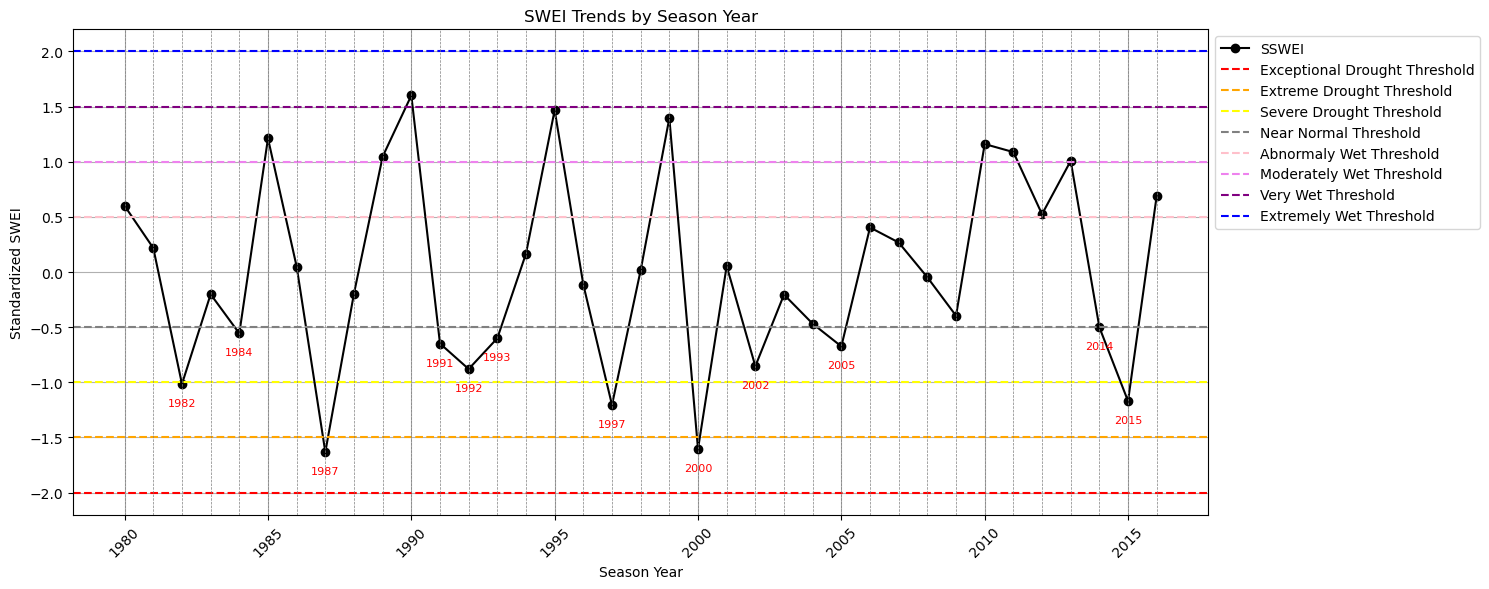

In [165]:
# Extract necessary columns
plot_data= average_SSWEI_per_year[['Season_year', 'SSWEI', 'Classification']]

# Sort by Season_year for better plotting
plot_data = plot_data.sort_values(by='Season_year')
plt.figure(figsize=(15, 6))
plt.plot(plot_data['Season_year'], plot_data['SSWEI'], marker='o', label='SSWEI', color='black')

# Add thresholds for drought classifications
plt.axhline(-2.0, color='r', linestyle='--', label='Exceptional Drought Threshold')
plt.axhline(-1.5, color='orange', linestyle='--', label='Extreme Drought Threshold')
plt.axhline(-1.0, color='yellow', linestyle='--', label='Severe Drought Threshold')
plt.axhline(-0.5, color='gray', linestyle='--', label='Near Normal Threshold')
plt.axhline(0.5, color='pink', linestyle='--', label='Abnormaly Wet Threshold')
plt.axhline(1.0, color='violet', linestyle='--', label='Moderately Wet Threshold')
plt.axhline(1.5, color='purple', linestyle='--', label='Very Wet Threshold')
plt.axhline(2.0, color='blue', linestyle='--', label='Extremely Wet Threshold')

# trend line
#z = np.polyfit(plot_data['Season_year'], plot_data['SSWEI'], 1)
#p = np.poly1d(z)
#plt.plot(plot_data['Season_year'],p(plot_data['Season_year']),"g--", label='trend line')

# Customize the plot
plt.title('SWEI Trends by Season Year')
plt.xlabel('Season Year')
plt.ylabel('Standardized SWEI')
plt.xticks(rotation=45)
# put legend outside the plot right top 
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# Add gridlines for each year
for year in plot_data['Season_year'].unique():
    plt.axvline(year, color='gray', linestyle='--', linewidth=0.5)
# Add years to SWEI< -0.5 years
for i, row in plot_data.iterrows():
    if row['SSWEI'] < -0.5:
        plt.text(row['Season_year'], row['SSWEI'] - 0.2, str(row['Season_year']), fontsize=8, color='red', ha='center')
plt.grid()
plt.tight_layout()
plt.savefig(output_path + 'SWEI_trends.png')
plt.show()
plt.close()

# Heldmyer classification

In [129]:
# Add cumulative P values for each season year and coordinate_id
onset_to_peak['cumulative_P'] = onset_to_peak.groupby(['season_year', 'coordinate_id'])['P'].cumsum()

# keep only time, coordinate_id, SWE, P, cumulative_P columns
onset_to_peak = onset_to_peak[['season_year', 'coordinate_id', 'SWE', 'P', 'cumulative_P']] 

# Display the updated dataframe
display(onset_to_peak)

,season_year,coordinate_id,SWE,P,cumulative_P
294,1980,2,12.762125,0.664867,0.664867
295,1980,2,12.599363,0.062945,0.727812
296,1980,2,12.029484,0.000000,0.727812
297,1980,2,12.559414,0.308135,1.035947
298,1980,2,14.034721,0.848068,1.884015
...,...,...,...,...,...
291233,2016,19,389.295044,1.255833,278.087219
291234,2016,19,391.886200,0.202527,278.289734
291235,2016,19,394.390015,0.245193,278.534943
291236,2016,19,396.296539,0.003266,278.538208


In [130]:

# Initialize an empty DataFrame to store the results
onset_to_peak_mean_all = pd.DataFrame()

# Iterate through each coordinate_id
for coordinate_id in onset_to_peak['coordinate_id'].unique():
    # Filter the data for the current coordinate_id
    coord_data = onset_to_peak[onset_to_peak['coordinate_id'] == coordinate_id]
    
    # Calculate mean_SWE for each season year
    coord_data['mean_SWE'] = coord_data.groupby('season_year')['SWE'].transform('mean')
    
    # Calculate mean_SWE for each season year and select max cumulative_P for each season year
    onset_to_peak_mean = coord_data.groupby('season_year').agg(
        mean_SWE=('SWE', 'mean'),
        mean_cumulative_P=('cumulative_P', 'mean'),
        max_SWE=('SWE', 'max'),
        max_cumulative_P=('cumulative_P', 'max')
    ).reset_index()

    # calculate cumulative P anomaly
    onset_to_peak_mean['cumulative_P_anomaly'] = onset_to_peak_mean['mean_cumulative_P'] - onset_to_peak_mean['mean_cumulative_P'].mean()
    
    # Calculate mean_SWE/max_cumulative_P ratio
    onset_to_peak_mean['mean_SWE/cumulative_P'] = onset_to_peak_mean['mean_SWE'] / onset_to_peak_mean['max_cumulative_P']
    
    # Add coordinate_id to the result
    onset_to_peak_mean['coordinate_id'] = coordinate_id
    
    # Append the result to the final DataFrame
    onset_to_peak_mean_all = pd.concat([onset_to_peak_mean_all, onset_to_peak_mean])

# Display the result
display(onset_to_peak_mean_all)

C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_38800\826272463.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coord_data['mean_SWE'] = coord_data.groupby('season_year')['SWE'].transform('mean')
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_38800\826272463.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coord_data['mean_SWE'] = coord_data.groupby('season_year')['SWE'].transform('mean')
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_38800\826272463.py:10: Settin

,season_year,mean_SWE,mean_cumulative_P,max_SWE,max_cumulative_P,cumulative_P_anomaly,mean_SWE/cumulative_P,coordinate_id
0,1980,171.529795,140.547104,294.600586,269.476685,34.043625,0.636529,2
1,1981,123.522472,94.756477,275.381927,209.734039,-11.747002,0.588948,2
2,1982,98.211099,79.827835,184.578796,146.192963,-26.675644,0.671791,2
3,1983,118.087998,90.920952,211.947189,195.835709,-15.582527,0.602995,2
4,1984,95.179610,81.743309,178.690857,159.872437,-24.760170,0.595347,2
...,...,...,...,...,...,...,...,...
32,2012,206.931667,147.850708,354.070709,258.031647,17.870941,0.801962,19
33,2013,197.705905,145.146072,447.697998,356.449707,15.166306,0.554653,19
34,2014,163.126465,135.663223,301.329865,256.753540,5.683456,0.635343,19
35,2015,103.925666,114.048340,223.613617,204.431519,-15.931427,0.508364,19


In [132]:
# Calculate the mean over coordinate_id
mean_over_coordinate_id = onset_to_peak_mean_all.groupby('season_year').mean().reset_index()

#drop coordinate_id
mean_over_coordinate_id = mean_over_coordinate_id.drop(['coordinate_id'], axis=1)

# Display the result
display(mean_over_coordinate_id)

,season_year,mean_SWE,mean_cumulative_P,max_SWE,max_cumulative_P,cumulative_P_anomaly,mean_SWE/cumulative_P
0,1980,169.830153,152.026733,283.587663,273.571136,29.879572,0.625317
1,1981,141.475820,119.866684,277.554440,239.948654,-2.280484,0.591291
2,1982,114.033175,93.282532,197.733494,168.364532,-28.864639,0.686755
3,1983,119.313631,99.426865,202.264634,193.412460,-22.720303,0.621705
4,1984,112.891217,92.937218,191.969439,176.112030,-29.209951,0.645230
5,1985,176.605270,134.737579,320.881080,290.114319,12.590398,0.603093
6,1986,138.884052,106.909164,236.692132,201.000946,-15.238007,0.692400
7,1987,101.492069,78.573936,200.063532,166.580750,-43.573235,0.619724
8,1988,130.621735,124.319130,266.174341,258.568512,2.171959,0.514675
9,1989,181.630373,161.049271,314.172343,304.236938,38.902096,0.600190


In [133]:
# Select snow drought years max_SWE< mean max_SWE
snow_drought_years = mean_over_coordinate_id[mean_over_coordinate_id['max_SWE'] < mean_over_coordinate_id['max_SWE'].mean()]

# Display the result
display(snow_drought_years)

,season_year,mean_SWE,mean_cumulative_P,max_SWE,max_cumulative_P,cumulative_P_anomaly,mean_SWE/cumulative_P
2,1982,114.033175,93.282532,197.733494,168.364532,-28.864639,0.686755
3,1983,119.313631,99.426865,202.264634,193.412460,-22.720303,0.621705
4,1984,112.891217,92.937218,191.969439,176.112030,-29.209951,0.645230
6,1986,138.884052,106.909164,236.692132,201.000946,-15.238007,0.692400
7,1987,101.492069,78.573936,200.063532,166.580750,-43.573235,0.619724
11,1991,134.181988,110.700661,219.435501,194.393234,-11.446508,0.712319
12,1992,102.676974,87.283615,219.605661,191.947083,-34.863552,0.532860
13,1993,120.914115,103.469612,238.740277,211.117020,-18.677561,0.586941
16,1996,137.176706,115.175247,236.148316,204.536270,-6.971920,0.687996
17,1997,98.067372,84.273148,189.410532,164.173737,-37.874023,0.600779


In [134]:
# normal years max_SWE> mean max_SWE
normal_years = mean_over_coordinate_id[mean_over_coordinate_id['max_SWE'] > mean_over_coordinate_id['max_SWE'].mean()]

# Display the result
display(normal_years)

,season_year,mean_SWE,mean_cumulative_P,max_SWE,max_cumulative_P,cumulative_P_anomaly,mean_SWE/cumulative_P
0,1980,169.830153,152.026733,283.587663,273.571136,29.879572,0.625317
1,1981,141.475820,119.866684,277.554440,239.948654,-2.280484,0.591291
5,1985,176.605270,134.737579,320.881080,290.114319,12.590398,0.603093
8,1988,130.621735,124.319130,266.174341,258.568512,2.171959,0.514675
9,1989,181.630373,161.049271,314.172343,304.236938,38.902096,0.600190
10,1990,222.744700,206.942841,369.720869,347.736938,84.795677,0.648136
14,1994,145.920598,123.901543,279.800537,261.181213,1.754371,0.563764
15,1995,192.939422,172.062363,339.310992,319.391876,49.915195,0.604538
19,1999,186.675596,174.409363,339.148796,318.637512,52.262199,0.586514
21,2001,144.178197,116.690811,292.426721,249.936935,-5.456355,0.574532


K mean Clustering for snow drought years

In [135]:
# standadize the cumulative P anomaly and mean_SWE/cumulative_P
snow_drought_years['cumulative_P_anomaly_z'] = (snow_drought_years['cumulative_P_anomaly'] - snow_drought_years['cumulative_P_anomaly'].mean()) / snow_drought_years['cumulative_P_anomaly'].std()
snow_drought_years['mean_SWE/cumulative_P_z'] = (snow_drought_years['mean_SWE/cumulative_P'] - snow_drought_years['mean_SWE/cumulative_P'].mean()) / snow_drought_years['mean_SWE/cumulative_P'].std()

# Display the result
display(snow_drought_years)

C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_38800\3440163260.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snow_drought_years['cumulative_P_anomaly_z'] = (snow_drought_years['cumulative_P_anomaly'] - snow_drought_years['cumulative_P_anomaly'].mean()) / snow_drought_years['cumulative_P_anomaly'].std()
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_38800\3440163260.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snow_drought_years['mean_SWE/cumulative_P_z'] = (snow_drought

,season_year,mean_SWE,mean_cumulative_P,max_SWE,max_cumulative_P,cumulative_P_anomaly,mean_SWE/cumulative_P,cumulative_P_anomaly_z,mean_SWE/cumulative_P_z
2,1982,114.033175,93.282532,197.733494,168.364532,-28.864639,0.686755,-0.444072,0.905618
3,1983,119.313631,99.426865,202.264634,193.412460,-22.720303,0.621705,-0.088135,0.003326
4,1984,112.891217,92.937218,191.969439,176.112030,-29.209951,0.645230,-0.464076,0.329629
6,1986,138.884052,106.909164,236.692132,201.000946,-15.238007,0.692400,0.345310,0.983913
7,1987,101.492069,78.573936,200.063532,166.580750,-43.573235,0.619724,-1.296132,-0.024156
11,1991,134.181988,110.700661,219.435501,194.393234,-11.446508,0.712319,0.564949,1.260205
12,1992,102.676974,87.283615,219.605661,191.947083,-34.863552,0.532860,-0.791585,-1.229013
13,1993,120.914115,103.469612,238.740277,211.117020,-18.677561,0.586941,0.146059,-0.478871
16,1996,137.176706,115.175247,236.148316,204.536270,-6.971920,0.687996,0.824159,0.922829
17,1997,98.067372,84.273148,189.410532,164.173737,-37.874023,0.600779,-0.965980,-0.286933


In [145]:
# K-means clustering
from sklearn.cluster import KMeans

# Rename the column to remove the tab character
snow_drought_years.rename(columns={'\tmean_SWE/cumulative_P': 'mean_SWE/cumulative_P'}, inplace=True)

cluster_feature = snow_drought_years[['mean_SWE/cumulative_P_z','cumulative_P_anomaly_z']]

#K = 3
kmean = KMeans(n_clusters=3,random_state=0)

#Fit the model and predict cluster labels

snow_drought_years['cluster'] = kmean.fit_predict(cluster_feature)

# Print the cluster centers and assigned clusters
print("Cluster centers:\n", kmean.cluster_centers_)
print("\nAssigned clusters:\n", snow_drought_years[['season_year', 'cluster']])

C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_38800\4148217731.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snow_drought_years.rename(columns={'\tmean_SWE/cumulative_P': 'mean_SWE/cumulative_P'}, inplace=True)
c:\Users\walimunige.rupasingh\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\walimunige.rupasingh\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variabl

Cluster centers:
 [[-0.66487374  0.96477621]
 [-0.78130307 -1.23466291]
 [ 0.78957578  0.03846595]]

Assigned clusters:
     season_year  cluster
2          1982        2
3          1983        2
4          1984        2
6          1986        2
7          1987        1
11         1991        2
12         1992        1
13         1993        0
16         1996        2
17         1997        1
18         1998        0
20         2000        1
22         2002        1
23         2003        0
24         2004        2
25         2005        2
27         2007        0
28         2008        0
29         2009        2
34         2014        0
35         2015        2


C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_38800\4148217731.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snow_drought_years['cluster'] = kmean.fit_predict(cluster_feature)


C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_38800\893111125.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snow_drought_years['cluster_name'] = snow_drought_years['cluster'].map(cluster_labels)


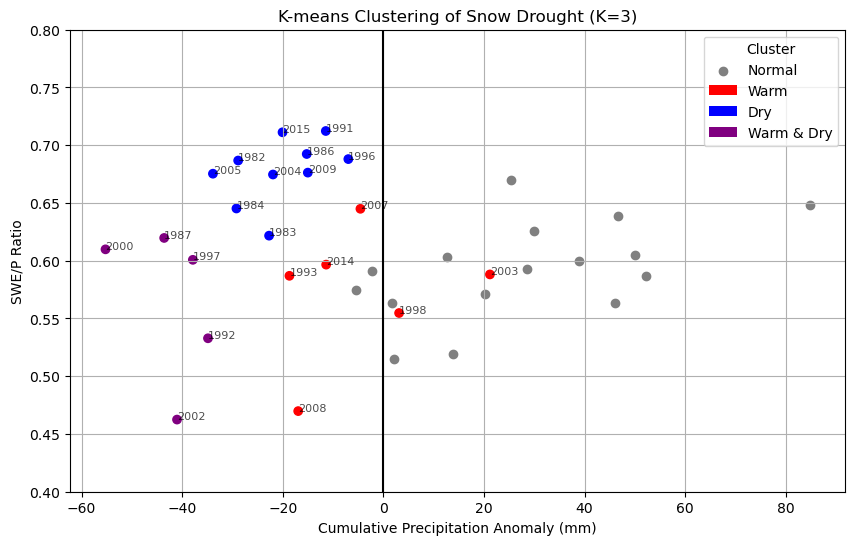

In [159]:
# Assign names to clusters based on their characteristics
cluster_labels = {
    0: 'Warm',        # Replace 0, 1, 2 with the actual cluster numbers after inspection
    1: 'Warm & Dry',
    2: 'Dry'
    
}

# Map cluster numbers to names in the DataFrame
snow_drought_years['cluster_name'] = snow_drought_years['cluster'].map(cluster_labels)

plt.figure(figsize=(10, 6))

# Define colors for each cluster (adjust colors as needed)
cluster_colors = {'Warm': 'red', 'Dry': 'blue', 'Warm & Dry': 'purple'}

plt.scatter(snow_drought_years['cumulative_P_anomaly'], snow_drought_years['mean_SWE/cumulative_P'], c=snow_drought_years['cluster_name'].map(cluster_colors))
plt.scatter(normal_years['cumulative_P_anomaly'], normal_years['mean_SWE/cumulative_P'], c='grey', label='Normal')
plt.xlabel('Cumulative Precipitation Anomaly (mm)')
plt.ylabel('SWE/P Ratio')
# Add a darker gridline for y-axis at 0
plt.axvline(0, color='black', linewidth=1.5, linestyle='-')  # Darker and thicker line for y=0
#add drought year to each dot
for i, row in snow_drought_years.iterrows():
    plt.annotate(row['season_year'], (row['cumulative_P_anomaly'], row['mean_SWE/cumulative_P']), fontsize=8, color='black', alpha=0.7)
# Create a legend for named clusters
for name, color in cluster_colors.items():
    plt.bar(0, 0, color=color, label=name)
plt.legend(title='Cluster')
plt.title('K-means Clustering of Snow Drought (K=3)')
plt.ylim(0.4,0.8)
plt.grid(True)
plt.savefig(output_path + 'K-means Clustering of Seasonal Data (K=3).png')
plt.show()